In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, f1_score, fbeta_score, precision_score, recall_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import ParameterGrid
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm.notebook import tqdm
import csv
from gensim.models.callbacks import CallbackAny2Vec
from itertools import groupby
from gensim.models import Word2Vec
import gensim
from pathlib import Path
import matplotlib.pyplot as plt
import os
import random
import collections
import pickle
from sklearn.preprocessing import MinMaxScaler
import time
pd.options.display.max_columns = 999

In [2]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [4]:
def my_metrics(regression_model, X_train, X_test, y_train, y_test, print_model=True):
    def adj_r2_score(r2, n, p):
        return (1-(1-r2)*(n-1)/(n-p-1))
    metric_dict = {}
    metric_dict['r2_score'] = regression_model.score(X_train, y_train)
    metric_dict['adjusted_r2_score'] = adj_r2_score(regression_model.score(X_train, y_train), X_train.shape[0], X_train.shape[1])
    metric_dict['rmse(test data)'] = mean_squared_error(y_test, regression_model.predict(X_test), squared=False)
    metric_dict['rmse(train data)'] = mean_squared_error(y_train, regression_model.predict(X_train), squared=False)
    if print_model:
        print(regression_model)
    return metric_dict

In [5]:
load_PATH = Path('/home/hsien/110/sta/final_pkfile/')

In [6]:
for dirname, _, filenames in os.walk(load_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/hsien/110/sta/final_pkfile/imdb_df_genres_title_cgname.pk
/home/hsien/110/sta/final_pkfile/w2v_crew_arr_50.pk
/home/hsien/110/sta/final_pkfile/bestw2v_model_crew.wv.vectors.npy
/home/hsien/110/sta/final_pkfile/cast_onehot_df.pk
/home/hsien/110/sta/final_pkfile/w2v_cast_arr_50.pk
/home/hsien/110/sta/final_pkfile/bestw2v_model_crew.syn1neg.npy
/home/hsien/110/sta/final_pkfile/crew_onehot_df.pk
/home/hsien/110/sta/final_pkfile/bestw2v_model_crew
/home/hsien/110/sta/final_pkfile/bestw2v_model.wv.vectors.npy
/home/hsien/110/sta/final_pkfile/bestw2v_model
/home/hsien/110/sta/final_pkfile/bestw2v_model.syn1neg.npy
/home/hsien/110/sta/final_pkfile/crew_50_sparse_df.pk
/home/hsien/110/sta/final_pkfile/w2v_crew_arr.pk
/home/hsien/110/sta/final_pkfile/cast_50_sparse_df.pk
/home/hsien/110/sta/final_pkfile/w2v_cast_arr.pk


# Load
此檔已有
1. genres和titleType的one-hot
2. change_name欄位

還沒刪除['originalTitle', 'endYear', 'titleType', 'genres', 'cast', 'crew']

In [7]:
with open(load_PATH / 'imdb_df_genres_title_cgname.pk', 'rb') as f:
    imdb_df = pickle.load(f)

## Load cast跟crew的one hot df
min_count = 50

In [9]:
with open(load_PATH / 'cast_onehot_df.pk', 'rb') as f:
    cast_onehot_df = pickle.load(f)

In [10]:
# with open(load_PATH / 'cast_50_sparse_df.pk', 'rb') as f:
#     cast_onehot_df = pickle.load(f)

In [11]:
cast_onehot_df.shape

(203521, 1121)

In [12]:
with open(load_PATH / 'crew_onehot_df.pk', 'rb') as f:
    crew_onehot_df = pickle.load(f)

In [13]:
# with open(load_PATH / 'crew_50_sparse_df.pk', 'rb') as f:
#     crew_onehot_df = pickle.load(f)

In [14]:
crew_onehot_df.shape

(203521, 1091)

## Load Word2Vec model
### cast

In [16]:
wtv_cast = Word2Vec.load('/home/jack/0_Other HW/SLDL Project/model/cast_50_model')

### crew

In [18]:
wtv_crew = Word2Vec.load('/home/jack/0_Other HW/SLDL Project/model/crew_50_model')

### 得到所有資料的cast跟crew的矩陣
每個row vector就是每筆data的cast Word2Vec vector

In [19]:
def get_vec(wtv, cast_list): # 我用平均
    if (np.array(sum(wtv.wv[c] for c in cast_list if wtv.wv.has_index_for(c))).shape) == (300,):
        return np.array(sum(wtv.wv[c] for c in cast_list if wtv.wv.has_index_for(c))) / len(cast_list)
    else:
        return np.zeros((300,), dtype=float)

In [20]:
imdb_df.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres', 'averageRating',
       'numVotes', 'cast', 'crew', 'change_name', 'movie', 'short',
       'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort',
       'tvSpecial', 'video', 'videoGame', 'Action', 'Adult', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western'],
      dtype='object')

In [21]:
imdb_df['cast'][1]

['nm0570615', 'nm0395667', 'nm0934211', 'nm0569795']

In [22]:
# w2v_cast_arr = np.asarray(list(get_vec(wtv_cast, x) for x in imdb_df['cast']), dtype="float64")
with open('final_pkfile/w2v_cast_arr_50.pk', 'rb') as f:
    w2v_cast_arr = pickle.load(f)

In [23]:
w2v_cast_arr.shape

(203521, 300)

In [24]:
# w2v_crew_arr = np.asarray(list(get_vec(wtv_crew, x) for x in imdb_df['crew']), dtype="float64")
with open('final_pkfile/w2v_crew_arr_50.pk', 'rb') as f:
    w2v_crew_arr = pickle.load(f)

In [25]:
w2v_crew_arr.shape

(203521, 300)

In [26]:
np.where((np.equal(w2v_cast_arr, w2v_crew_arr))==True)

(array([    99,     99,     99, ..., 203517, 203517, 203517]),
 array([  0,   1,   2, ..., 297, 298, 299]))

# Training

### 刪除['originalTitle', 'endYear', 'titleType', 'genres', 'cast', 'crew', 'tconst', 'primaryTitle']

In [29]:
df = imdb_df.drop(columns=['originalTitle', 'endYear', 'titleType', 'genres', 'cast', 'crew', 'tconst', 'primaryTitle'], inplace=False)

In [30]:
df.head(5)

,isAdult,startYear,runtimeMinutes,averageRating,numVotes,change_name,movie,short,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvShort,tvSpecial,video,videoGame,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,1961,88.0,4.2,84,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1961,60.0,8.2,30,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,1961,77.0,5.8,15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1961,97.0,5.9,18,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1961,60.0,7.7,21,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## 資料集一

# feature importance

In [31]:
X = df.drop(columns=['averageRating'], inplace=False).loc[:, :]
y = np.ravel(df.loc[:, df.columns == 'averageRating'])

In [32]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
forest = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=9)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, n_jobs=-1, random_state=0)

In [35]:
my_metrics(forest, X_train, X_test, y_train, y_test, print_model=True)

RandomForestRegressor(max_depth=9, n_jobs=-1, random_state=0)


{'r2_score': 0.3910459687536514,
 'adjusted_r2_score': 0.3908888415316162,
 'rmse(test data)': 1.0911450732487256,
 'rmse(train data)': 1.0843885571867657}

In [37]:
feature_names = list((df.drop(columns=['averageRating'])).columns)

In [38]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.023 seconds


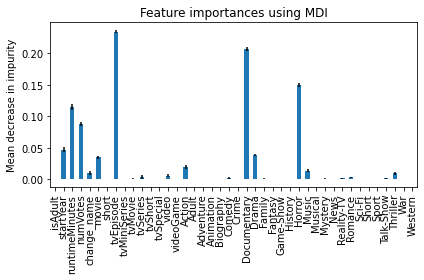

In [39]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [40]:
imp_df = pd.DataFrame(forest_importances,columns=['MDI'])
imp_df.sort_values(by=['MDI'], ascending=False).T

,tvEpisode,Documentary,Horror,runtimeMinutes,numVotes,startYear,Drama,movie,Action,Music,change_name,Thriller,video,tvSeries,Romance,Comedy,Reality-TV,Talk-Show,Mystery,tvMovie,Family,Biography,Animation,Crime,Sci-Fi,Adventure,tvSpecial,tvMiniSeries,News,Fantasy,Sport,History,War,Game-Show,Western,isAdult,Adult,Musical,videoGame,Short,tvShort,short
MDI,0.234707,0.207176,0.150114,0.115313,0.087659,0.047258,0.039275,0.034988,0.02016,0.013998,0.01028,0.009957,0.005861,0.00403,0.003319,0.002396,0.001722,0.001574,0.001077,0.00104,0.001029,0.00077,0.000675,0.00066,0.000635,0.000601,0.000588,0.00049,0.000457,0.000446,0.000404,0.000357,0.000301,0.000229,0.000147,0.000146,0.000088,0.000072,9.585915e-07,8.287844e-07,0.0,0.0


# 只看前20個

In [41]:
imp_set = set((imp_df.sort_values(by=['MDI'], ascending=False).index)[:20])

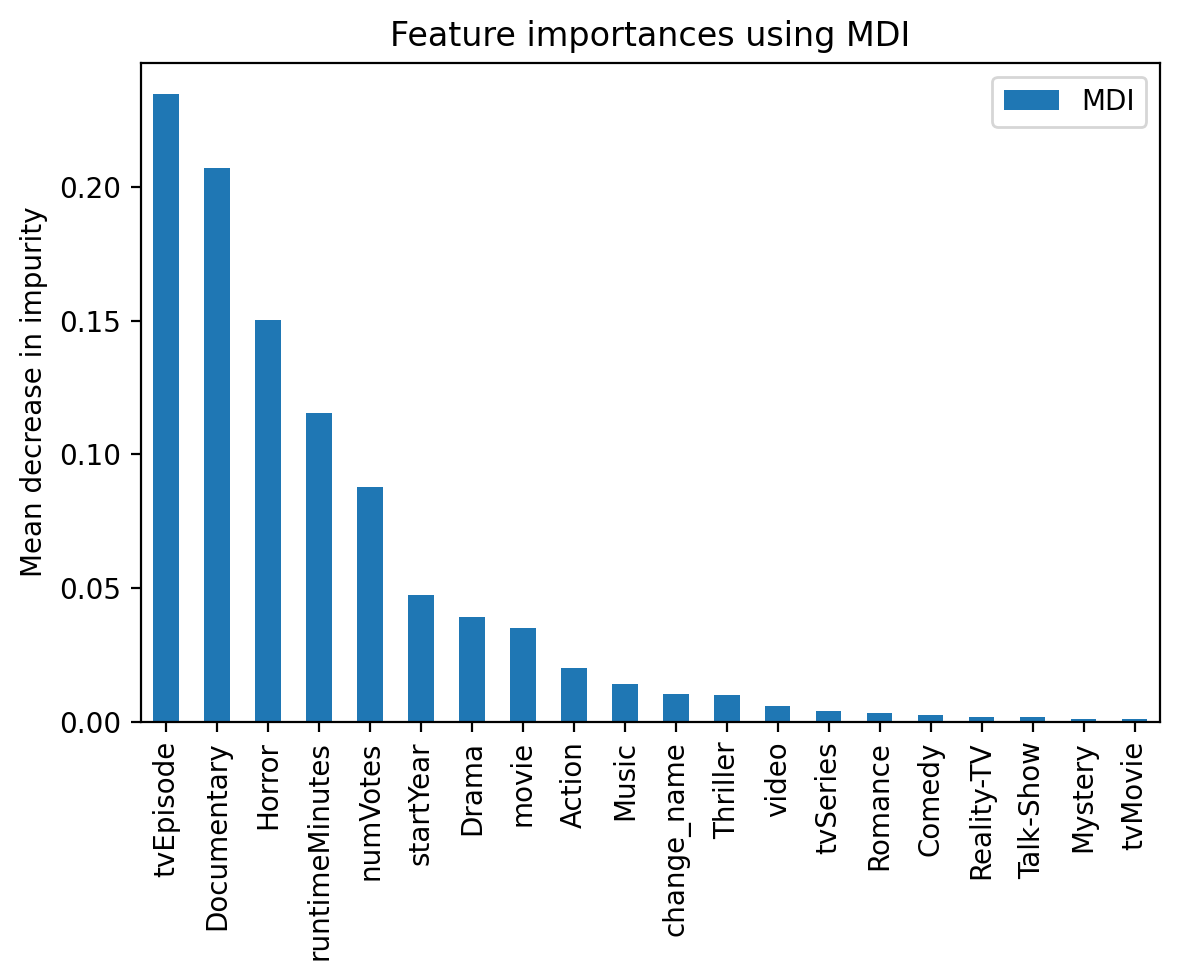

In [42]:
fig, ax = plt.subplots(figsize=(6,5),dpi=200)
imp_df.sort_values(by=['MDI'], ascending=False).iloc[:20].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## cast crew 用 one-hot encoding 表示

In [47]:
oh_result = {}

補上cast one hot 

In [48]:
df_one_hot = pd.concat((df, cast_onehot_df), axis=1)

In [49]:
df_one_hot = pd.concat((df_one_hot, crew_onehot_df), axis=1)

In [50]:
df_one_hot.shape

(203521, 2255)

In [51]:
X = df_one_hot.drop(columns=['averageRating'], inplace=False).loc[:, :]
y = np.ravel(df_one_hot.loc[:, df_one_hot.columns == 'averageRating'])

### 先過MinMax

In [52]:
scaler = MinMaxScaler()

In [53]:
X = scaler.fit_transform(X)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## rf

In [55]:
forest_oh = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=9)
forest_oh.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, n_jobs=-1, random_state=0)

In [56]:
my_metrics(forest_oh, X_train, X_test, y_train, y_test, print_model=True)

RandomForestRegressor(max_depth=9, n_jobs=-1, random_state=0)


{'r2_score': 0.3900168602449565,
 'adjusted_r2_score': 0.3814537471788454,
 'rmse(test data)': 1.091109194928172,
 'rmse(train data)': 1.085304457527532}

In [57]:
start_time = time.time()
importances = forest_oh.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_oh.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.016 seconds


In [58]:
feature_names = list((df_one_hot.drop(columns=['averageRating'])).columns)

In [59]:
forest_importances = pd.Series(importances, index=feature_names)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

In [60]:
imp_df_oh = pd.DataFrame(forest_importances,columns=['MDI'])
imp_df_oh.sort_values(by=['MDI'], ascending=False)

,MDI
tvEpisode,0.235486
Documentary,0.207592
Horror,0.150321
runtimeMinutes,0.114015
numVotes,0.084402
...,...
nm0489858,0.000000
nm0289960,0.000000
nm0222643,0.000000
nm0007102,0.000000


In [61]:
imp_df_oh.sort_values(by=['MDI'], ascending=False).iloc[:20]

,MDI
tvEpisode,0.235486
Documentary,0.207592
Horror,0.150321
runtimeMinutes,0.114015
numVotes,0.084402
startYear,0.043277
Drama,0.038882
movie,0.034981
Action,0.019935
Music,0.013888


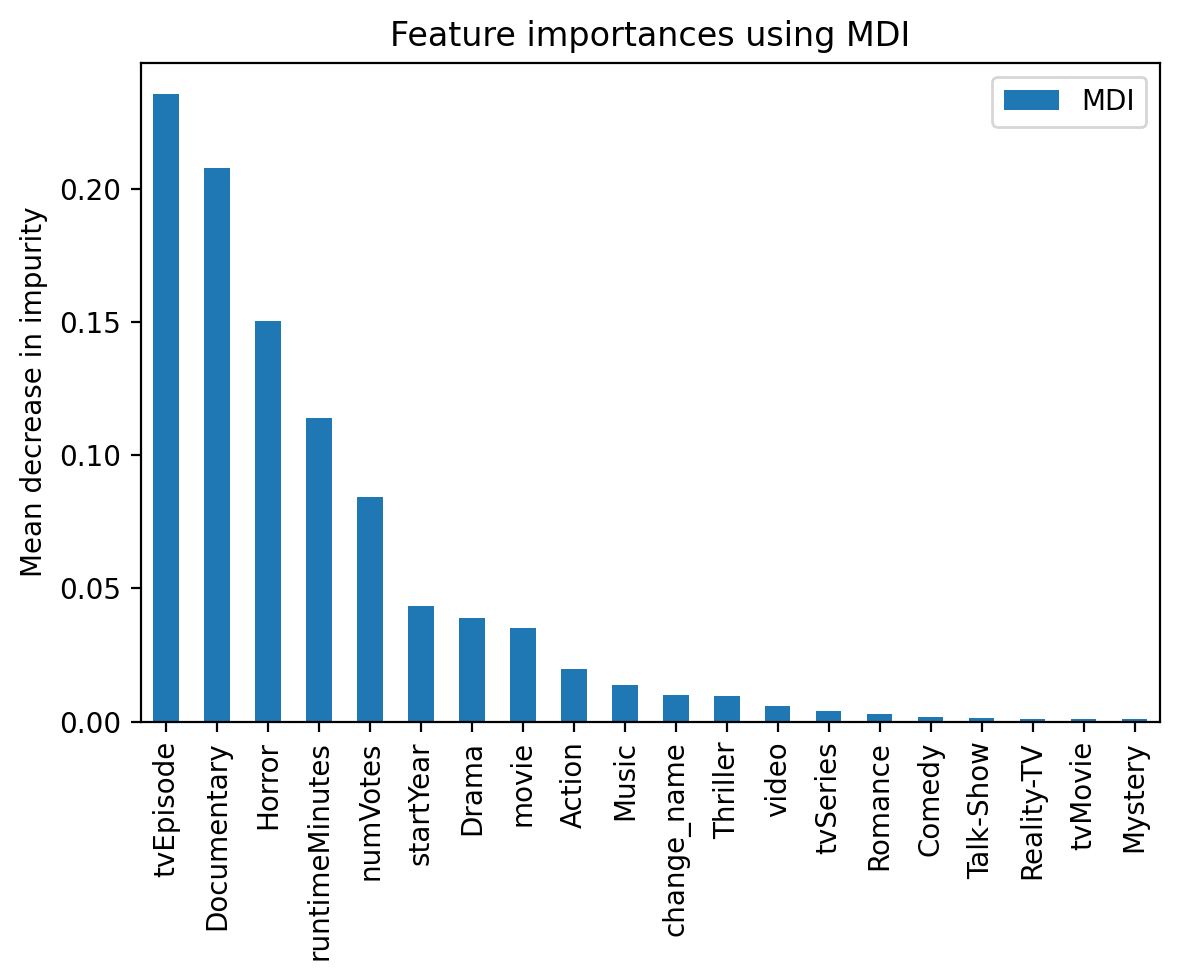

In [62]:
fig, ax = plt.subplots(figsize=(6,5),dpi=200)
imp_df_oh.sort_values(by=['MDI'], ascending=False).iloc[:20].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [63]:
imp_set_oh = set((imp_df_oh.sort_values(by=['MDI'], ascending=False).index)[:20])

In [64]:
imp_set_oh

{'Action',
 'Comedy',
 'Documentary',
 'Drama',
 'Horror',
 'Music',
 'Mystery',
 'Reality-TV',
 'Romance',
 'Talk-Show',
 'Thriller',
 'change_name',
 'movie',
 'numVotes',
 'runtimeMinutes',
 'startYear',
 'tvEpisode',
 'tvMovie',
 'tvSeries',
 'video'}

## cast crew 用 Word2Vec 表示

In [66]:
w2v_result = {}

In [67]:
# df_w2v = pd.concat((df, cast_onehot_df), axis=1)

In [68]:
# df_one_hot = pd.concat((df_one_hot, crew_onehot_df), axis=1)

In [69]:
# df_one_hot.shape

In [70]:
X = np.array(df.drop(columns=['averageRating'], inplace=False).loc[:, :])
y = np.ravel(df.loc[:, df.columns == 'averageRating'])

補上cast crew arr

In [71]:
X = np.concatenate((X, w2v_cast_arr), axis=1)
X = np.concatenate((X, w2v_crew_arr), axis=1)

In [72]:
X.shape

(203521, 642)

### 先過MinMax

In [73]:
scaler = MinMaxScaler()

In [74]:
X = scaler.fit_transform(X)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## rf

In [76]:
start = time.time()
forest_w2v = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=9)
forest_w2v.fit(X_train, y_train)
end = time.time()

In [77]:
my_metrics(forest_w2v, X_train, X_test, y_train, y_test, print_model=True)

RandomForestRegressor(max_depth=9, n_jobs=-1, random_state=0)


{'r2_score': 0.41160232441565836,
 'adjusted_r2_score': 0.4092730136936199,
 'rmse(test data)': 1.0810906588244902,
 'rmse(train data)': 1.0659286747721843}

In [78]:
mean_squared_error(y_train, forest_w2v.predict(X_train), squared=False)

1.0659286747721843

# 加入Title的bert

In [79]:
with open('/home/jack/0_Other HW/SLDL Project/model/df_bert.pk', 'rb') as f:
    df_bert = pickle.load(f)

In [80]:
df_bert

bertdim1  bertdim2  bertdim3  bertdim4  bertdim5  bertdim6  bertdim7  \
0      -0.808446  0.531357  0.999978 -0.997249  0.976660  0.736699  0.991883   
1      -0.801082  0.600533  0.999987 -0.997582  0.981994  0.743360  0.987109   
2      -0.799335  0.539186  0.999974 -0.995560  0.969992  0.332953  0.984201   
3      -0.791939  0.533764  0.999982 -0.994044  0.982556  0.138356  0.984055   
4      -0.794213  0.590708  0.999986 -0.997450  0.983491  0.744515  0.989851   
...          ...       ...       ...       ...       ...       ...       ...   
203516 -0.829577  0.614411  0.999984 -0.997057  0.972475  0.645951  0.996290   
203517 -0.705849  0.484358  0.999938 -0.996463  0.967698  0.891910  0.986233   
203518 -0.816883  0.569761  0.999960 -0.994995  0.973453  0.752618  0.983180   
203519 -0.807530  0.520048  0.999977 -0.997869  0.978094  0.890757  0.993739   
203520 -0.640096  0.329986  0.999869 -0.989973  0.951135  0.870326  0.946751   

        bertdim8  bertdim9  bertdim10  bertdim11  bertdim12  bertdim13  \
0      -0.946218 -0.982858  -0.718163   0.991392   0.999400  -0.991241   
1      -0.899205 -0.991019  -0.611979   0.993453   0.999629  -0.982794   
2      -0.864574 -0.977825  -0.721972   0.993670   0.999075  -0.970924   
3      -0.778561 -0.970028  -0.755540   0.992894   0.999449  -0.980900   
4      -0.892761 -0.991016  -0.663410   0.994978   0.999630  -0.983109   
...          ...       ...        ...        ...        ...        ...   
203516 -0.871867 -0.990296  -0.761941   0.996921   0.999314  -0.975840   
203517 -0.986882 -0.978663  -0.607660   0.990181   0.999385  -0.997578   
203518 -0.923110 -0.989151  -0.746955   0.990305   0.998990  -0.979975   
203519 -0.967993 -0.992112  -0.731037   0.996383   0.999659  -0.995734   
203520 -0.988864 -0.971119  -0.630503   0.983555   0.998951  -0.998833   

        bertdim14  bertdim15  bertdim16  bertdim17  bertdim18  bertdim19  \
0       -0.999946   0.550146  -0.988879   0.995279  -0.617631  -0.999994   
1       -0.999957   0.537526  -0.991906   0.995273  -0.691133  -0.999996   
2       -0.999940  -0.130458  -0.973394   0.993426  -0.674760  -0.999992   
3       -0.999948   0.124297  -0.976297   0.993973  -0.625929  -0.999995   
4       -0.999964   0.472752  -0.992080   0.995394  -0.722798  -0.999996   
...           ...        ...        ...        ...        ...        ...   
203516  -0.999966  -0.140195  -0.992540   0.996370  -0.686434  -0.999995   
203517  -0.999842   0.785655  -0.982739   0.993663  -0.600456  -0.999986   
203518  -0.999937   0.283217  -0.986383   0.994068  -0.691759  -0.999990   
203519  -0.999952   0.758153  -0.992512   0.996410  -0.669152  -0.999995   
203520  -0.999747   0.801468  -0.975975   0.989738  -0.447821  -0.999976   

        bertdim20  bertdim21  bertdim22  bertdim23  bertdim24  bertdim25  \
0       -0.246386  -0.413076  -0.999978   0.285939   0.910307   0.992257   
1        0.013733  -0.169432  -0.999983   0.342686   0.869879   0.984001   
2        0.414431  -0.500462  -0.999957   0.366309   0.766247   0.982737   
3        0.160899   0.050945  -0.999966   0.336441   0.740667   0.988481   
4       -0.049797  -0.163790  -0.999985   0.355162   0.881345   0.982120   
...           ...        ...        ...        ...        ...        ...   
203516   0.092434  -0.549212  -0.999979   0.388451   0.852988   0.989531   
203517  -0.326022  -0.463750  -0.999949   0.306044   0.973825   0.978725   
203518  -0.080493  -0.185435  -0.999950   0.382654   0.884414   0.978328   
203519  -0.311761  -0.326070  -0.999971   0.377685   0.932253   0.990946   
203520  -0.649865  -0.119013  -0.999874   0.095802   0.962092   0.942066   

        bertdim26  bertdim27  bertdim28  bertdim29  bertdim30  bertdim31  \
0        0.061508   0.996241   0.999991   0.877216   0.473212   0.345479   
1        0.219684   0.996145   0.999996   0.828045   0.704869   0.382127   
2        0.110370   0.994131   0.999986   0.914221   0.592189   0.440553   
3        0.049645   0.991926

In [81]:
bert_arr = np.array(df_bert)

In [82]:
X = np.array(df.drop(columns=['averageRating'], inplace=False).loc[:, :])
y = np.ravel(df.loc[:, df.columns == 'averageRating'])

In [83]:
X = np.concatenate((X, w2v_cast_arr), axis=1)
X = np.concatenate((X, w2v_crew_arr), axis=1)

In [84]:
X = np.concatenate((X, bert_arr), axis=1)

### 先過MinMax

In [85]:
scaler = MinMaxScaler()

In [86]:
X = scaler.fit_transform(X)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## rf

In [88]:
forest_bert = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=9)
forest_bert.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, n_jobs=-1, random_state=0)

In [89]:
my_metrics(forest_bert, X_train, X_test, y_train, y_test, print_model=True)

RandomForestRegressor(max_depth=9, n_jobs=-1, random_state=0)


{'r2_score': 0.4118640701051606,
 'adjusted_r2_score': 0.406726238804075,
 'rmse(test data)': 1.0817572653890617,
 'rmse(train data)': 1.0656915619464553}